<a href="https://colab.research.google.com/github/suraj93/Intro-to-Quant-Modelling-CFA-2025/blob/main/Section_3_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 3: Risk Analysis
## Professional Risk Assessment for Portfolio Managers

**Duration:** 20 minutes  
**Objective:** Learn to calculate and interpret risk metrics that actually matter in practice

### What You'll Learn:
1. **Maximum Drawdown** - The pain your investors will feel (and remember)
2. **Value at Risk (VaR)** - Your daily risk budget for position sizing
3. **Sharpe Ratio** - Risk-adjusted returns (with caveats)
4. **Crisis Stress Testing** - When models fail (March 2020)
5. **Scenario Analysis** - "What if history repeats?"

### Philosophy:
> *"Risk is what's left when you think you've thought of everything."*  
> Our job: Quantify what we can, stress-test what we can't, and never trust a single number.

---
## Cell 1: Setup & Data Loading

**Purpose:** Load Smart Beta portfolio and prepare daily returns for risk analysis

**Smart Beta Portfolio:**
- NIFTYBEES: 15% (Large Cap)
- JUNIORBEES: 35% (Small Cap - highest weight for factor tilt)
- BANKBEES: 35% (Banking sector - concentrated bet)
- GOLDBEES: 15% (Alternative asset)
- LIQUIDBEES: 5% (Cash equivalent)

**Note:** This is a high-risk portfolio (70% equity, 35% small cap)

In [ ]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set professional plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure display
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


In [ ]:
# Portfolio definition
SMART_BETA = {
    'NIFTYBEES': 0.15,   # Nifty 50 ETF
    'JUNIORBEES': 0.35,  # Nifty Next 50 ETF (Small cap tilt)
    'BANKBEES': 0.35,    # Bank Nifty ETF
    'GOLDBEES': 0.15,    # Gold ETF
    'LIQUIDBEES': 0.05   # Liquid ETF (cash proxy)
}

# Parameters
START_DATE = '2019-01-01'
END_DATE = '2024-12-31'
PORTFOLIO_VALUE = 1_00_00_000  # ₹10 Crore base portfolio
RISK_FREE_RATE = 0.065  # 6.5% India 10Y G-Sec
BENCHMARK = 'NIFTY50'  # Nifty 50

# Crisis periods for stress testing
COVID_CRASH = ('2020-03-01', '2020-04-30')  # March-April 2020
INFLATION_GRIND = ('2022-10-01', '2022-12-31')  # Oct-Dec 2022
BULL_PERIOD = ('2019-01-01', '2019-12-31')  # 2019 trending market

print(f"Portfolio Value: ₹{PORTFOLIO_VALUE:,.0f}")
print(f"Analysis Period: {START_DATE} to {END_DATE}")
print(f"Risk-Free Rate: {RISK_FREE_RATE*100:.1f}%")

Portfolio Value: ₹10,000,000
Analysis Period: 2019-01-01 to 2024-12-31
Risk-Free Rate: 6.5%


In [ ]:
## Load price data from CSV
from google.colab import drive
drive.mount('/content/gdrive')
FILE_PATH = '/content/gdrive/My Drive/Finance AI/2025 CFA Quant workshop/data/india_market_data.csv'

print("Loading data from CSV...\n")
df = pd.read_csv(FILE_PATH)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)

# Select only needed columns for Smart Beta portfolio + benchmark
# CSV columns: NIFTYBEES, JUNIORBEES, BANKBEES, GOLDBEES, LIQUIDBEES, NIFTY50
portfolio_cols = ['NIFTYBEES', 'JUNIORBEES', 'BANKBEES', 'GOLDBEES', 'LIQUIDBEES']
benchmark_col = 'NIFTY50'

# Extract price data
data = df[portfolio_cols + [benchmark_col]].copy()

# Filter date range
data = data.loc[START_DATE:END_DATE]

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate daily returns
for asset in assets:
    returns_df[asset] = df[asset].pct_change()

# Remove first row (NaN from pct_change)
returns_df = returns_df.iloc[1:].reset_index(drop=True)

# Calculate individual asset cumulative returns
asset_cumulative = (1 + returns[list(SMART_BETA.keys())]).cumprod()

# Calculate portfolio value as weighted sum of drifting positions
portfolio_value = pd.Series(0, index=asset_cumulative.index)
for ticker, weight in SMART_BETA.items():
    portfolio_value += asset_cumulative[ticker] * weight

# Portfolio returns from value
portfolio_returns = portfolio_value.pct_change().dropna()

# Cumulative
cumulative_returns = portfolio_value

'''
portfolio_returns = pd.Series(0, index=returns.index)
for ticker, weight in SMART_BETA.items():
    portfolio_returns += returns[ticker] * weight
'''
portfolio_returns.name = 'Smart_Beta'

# Combine with benchmark
returns_combined = pd.DataFrame({
    'Portfolio': portfolio_returns,
    'Nifty_50': returns[BENCHMARK]
})

# Calculate cumulative returns for drawdown analysis
cumulative_returns = (1 + returns_combined).cumprod()

print("✓ Data downloaded and processed")
print(f"\nData Summary:")
print(f"  Trading days: {len(returns_combined)}")
print(f"  Date range: {returns_combined.index[0].date()} to {returns_combined.index[-1].date()}")
print(f"\nPortfolio Composition:")
for ticker, weight in SMART_BETA.items():
    print(f"  {ticker.replace('.NS', '').ljust(12)}: {weight*100:>5.1f}%")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Loading data from CSV...

✓ Data downloaded and processed

Data Summary:
  Trading days: 1480
  Date range: 2019-01-02 to 2024-12-31

Portfolio Composition:
  NIFTYBEES   :  15.0%
  JUNIORBEES  :  35.0%
  BANKBEES    :  35.0%
  GOLDBEES    :  15.0%
  LIQUIDBEES  :   5.0%


---
## Cell 2: Maximum Drawdown Analysis

**What is Maximum Drawdown?**
- Peak-to-trough decline in portfolio value
- Measures the **worst pain** an investor would have experienced
- Critical for understanding investor psychology and redemption risk

**Why It Matters:**
- Investors remember pain more than gains
- Drawdown duration kills funds (not just depth)
- Recovery time = opportunity cost + psychological stress

**Formula:**
```
Drawdown(t) = (Current Value - Peak Value) / Peak Value
Max Drawdown = min(all drawdowns)
```

In [ ]:
def calculate_drawdown(cumulative_returns):
    """
    Calculate drawdown series and maximum drawdown

    Returns:
    - drawdown_series: Daily drawdown from peak
    - max_dd: Maximum drawdown (most negative value)
    - max_dd_date: Date of maximum drawdown
    - recovery_date: Date portfolio recovered (or None if not recovered)
    """
    # Calculate running maximum (peak)
    running_max = cumulative_returns.cummax()

    # Calculate drawdown
    drawdown_series = (cumulative_returns - running_max) / running_max

    # Find maximum drawdown
    max_dd = drawdown_series.min()
    max_dd_date = drawdown_series.idxmin()

    # Find recovery date (if recovered)
    recovery_date = None
    after_max_dd = drawdown_series[max_dd_date:]
    recovery_mask = after_max_dd >= -0.001  # Within 0.1% of peak
    if recovery_mask.any():
        recovery_date = after_max_dd[recovery_mask].index[0]

    return drawdown_series, max_dd, max_dd_date, recovery_date

# Calculate drawdowns
portfolio_dd, portfolio_max_dd, portfolio_max_dd_date, portfolio_recovery = calculate_drawdown(
    cumulative_returns['Portfolio']
)
benchmark_dd, benchmark_max_dd, benchmark_max_dd_date, benchmark_recovery = calculate_drawdown(
    cumulative_returns['Nifty_50']
)

# Calculate recovery time
portfolio_recovery_days = (portfolio_recovery - portfolio_max_dd_date).days if portfolio_recovery else None
benchmark_recovery_days = (benchmark_recovery - benchmark_max_dd_date).days if benchmark_recovery else None

# Display results
print("="*70)
print("MAXIMUM DRAWDOWN ANALYSIS")
print("="*70)
print(f"\n{'Metric':<30} {'Portfolio':<20} {'Nifty 50':<20}")
print("-"*70)
print(f"{'Max Drawdown':<30} {portfolio_max_dd:>19.2%} {benchmark_max_dd:>19.2%}")
print(f"{'In Rupees (₹10Cr base)':<30} ₹{portfolio_max_dd*PORTFOLIO_VALUE:>17,.0f} ₹{benchmark_max_dd*PORTFOLIO_VALUE:>17,.0f}")
print(f"{'Date of Max DD':<30} {str(portfolio_max_dd_date.date()):<19} {str(benchmark_max_dd_date.date()):<19}")

if portfolio_recovery_days:
    print(f"{'Recovery Time (days)':<30} {portfolio_recovery_days:>19} {benchmark_recovery_days if benchmark_recovery_days else 'Not recovered':>19}")
else:
    print(f"{'Recovery Status':<30} {'Not yet recovered':<19} {'Not yet recovered':<19}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)

if abs(portfolio_max_dd) < abs(benchmark_max_dd):
    print(f"✓ Portfolio drawdown ({portfolio_max_dd:.2%}) was BETTER than benchmark ({benchmark_max_dd:.2%})")
    print(f"  → You lost LESS during the worst period (downside protection)")
else:
    print(f"✗ Portfolio drawdown ({portfolio_max_dd:.2%}) was WORSE than benchmark ({benchmark_max_dd:.2%})")
    print(f"  → You lost MORE during the worst period (concentrated risk)")

if portfolio_recovery_days and benchmark_recovery_days:
    if portfolio_recovery_days < benchmark_recovery_days:
        print(f"✓ Portfolio recovered FASTER ({portfolio_recovery_days} days vs {benchmark_recovery_days} days)")
    else:
        print(f"✗ Portfolio recovered SLOWER ({portfolio_recovery_days} days vs {benchmark_recovery_days} days)")

MAXIMUM DRAWDOWN ANALYSIS

Metric                         Portfolio            Nifty 50            
----------------------------------------------------------------------
Max Drawdown                               -31.47%             -38.44%
In Rupees (₹10Cr base)         ₹       -3,146,909 ₹       -3,843,985
Date of Max DD                 2020-03-23          2020-03-23         
Recovery Time (days)                           231                 231

INTERPRETATION:
✓ Portfolio drawdown (-31.47%) was BETTER than benchmark (-38.44%)
  → You lost LESS during the worst period (downside protection)
✗ Portfolio recovered SLOWER (231 days vs 231 days)


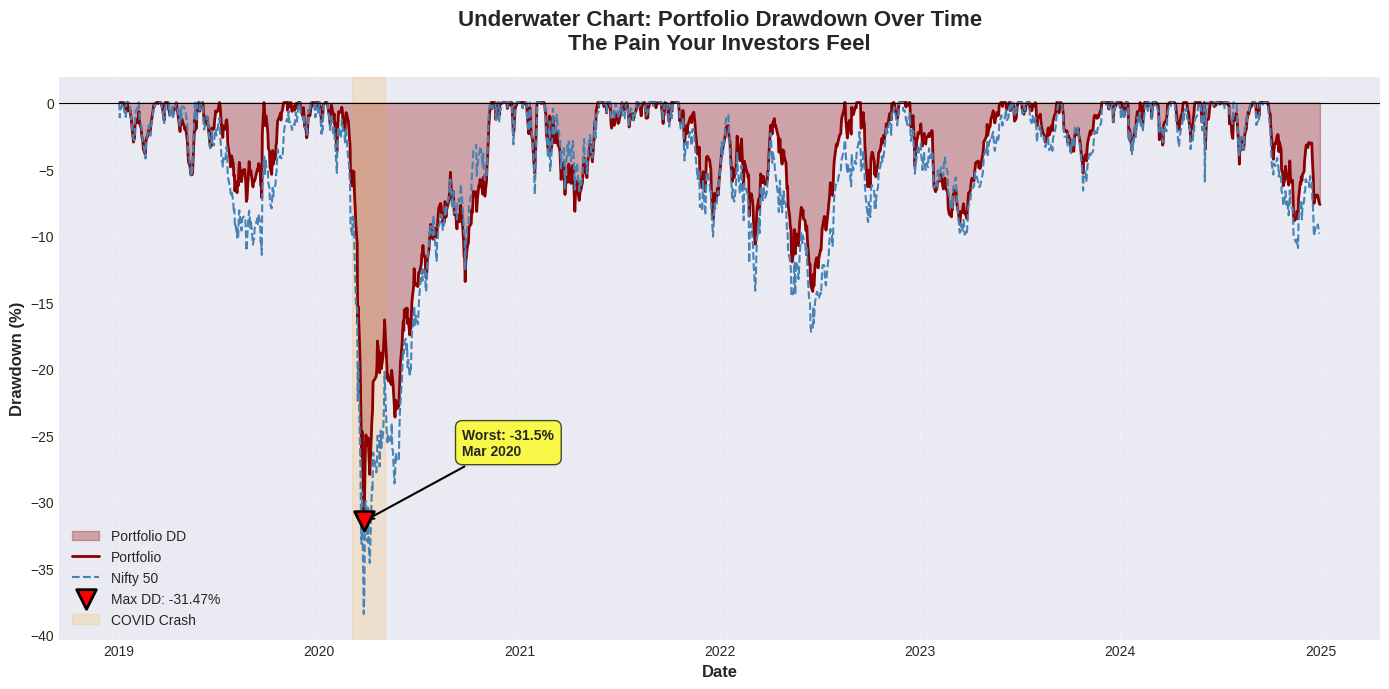


📊 KEY INSIGHT:
The deepest drawdown occurred in March 2020 (COVID crash)
An investor with ₹10 Crore would have seen their portfolio drop to ₹6,853,091
It took 231 days (~7 months) to recover

This is the PAIN test for your strategy. Can your investors survive this?


In [ ]:
# VISUAL: Underwater Chart (Drawdown over time)
fig, ax = plt.subplots(figsize=(14, 7))

# Plot drawdowns
ax.fill_between(portfolio_dd.index, portfolio_dd * 100, 0, alpha=0.3, color='darkred', label='Portfolio DD')
ax.plot(portfolio_dd.index, portfolio_dd * 100, color='darkred', linewidth=2, label='Portfolio')
ax.plot(benchmark_dd.index, benchmark_dd * 100, color='steelblue', linewidth=1.5, linestyle='--', label='Nifty 50')

# Mark maximum drawdown points
ax.scatter(portfolio_max_dd_date, portfolio_max_dd * 100, color='red', s=200, zorder=5,
           marker='v', edgecolors='black', linewidths=2, label=f'Max DD: {portfolio_max_dd:.2%}')

# Mark COVID crash period
ax.axvspan(pd.to_datetime(COVID_CRASH[0]), pd.to_datetime(COVID_CRASH[1]),
           alpha=0.15, color='orange', label='COVID Crash')

# Formatting
ax.set_title('Underwater Chart: Portfolio Drawdown Over Time\nThe Pain Your Investors Feel',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower left', fontsize=10, framealpha=0.9)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add annotations
ax.annotate(f'Worst: {portfolio_max_dd:.1%}\n{portfolio_max_dd_date.strftime("%b %Y")}',
            xy=(portfolio_max_dd_date, portfolio_max_dd * 100),
            xytext=(portfolio_max_dd_date + timedelta(days=180), portfolio_max_dd * 100 + 5),
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

plt.tight_layout()
plt.show()

print("\n📊 KEY INSIGHT:")
print(f"The deepest drawdown occurred in {portfolio_max_dd_date.strftime('%B %Y')} (COVID crash)")
print(f"An investor with ₹10 Crore would have seen their portfolio drop to ₹{(1+portfolio_max_dd)*PORTFOLIO_VALUE:,.0f}")
if portfolio_recovery_days:
    print(f"It took {portfolio_recovery_days} days (~{portfolio_recovery_days//30} months) to recover")
print(f"\nThis is the PAIN test for your strategy. Can your investors survive this?")

---
## Cell 3: Value at Risk (VaR) - Your Daily Risk Budget

**What is VaR?**
- "On X% of days, I won't lose more than Y%"
- VaR 95% = -2.3% means: On 19 out of 20 days, losses won't exceed 2.3%
- VaR 99% = -4.1% means: On 99 out of 100 days, losses won't exceed 4.1%

**How to Use VaR:**
- **Position sizing:** If VaR = 2%, size positions so total portfolio VaR stays within risk budget
- **Daily monitoring:** Did we breach VaR today? If yes, investigate why
- **Stop-loss levels:** Use VaR to set mechanical stop-losses

**Critical Caveat:**
- VaR tells you nothing about the 1% or 5% worst days
- In crises, losses can exceed VaR by multiples (see March 2020)
- VaR assumes historical distribution holds (fat tails break this)

In [ ]:
def calculate_var(returns, confidence_levels=[0.95, 0.99]):
    """
    Calculate Historical VaR at different confidence levels

    Returns dictionary with VaR values (negative = loss)
    """
    var_results = {}
    for conf in confidence_levels:
        var_value = returns.quantile(1 - conf)
        var_results[f'VaR_{int(conf*100)}%'] = var_value
    return var_results

# Calculate VaR for portfolio and benchmark
portfolio_var = calculate_var(returns_combined['Portfolio'])
benchmark_var = calculate_var(returns_combined['Nifty_50'])

# Calculate CVaR (Expected Shortfall) - average loss beyond VaR
portfolio_cvar_95 = returns_combined['Portfolio'][returns_combined['Portfolio'] <= portfolio_var['VaR_95%']].mean()
portfolio_cvar_99 = returns_combined['Portfolio'][returns_combined['Portfolio'] <= portfolio_var['VaR_99%']].mean()

# Display results
print("="*80)
print("VALUE AT RISK (VaR) - HISTORICAL METHOD")
print("="*80)
print(f"\n{'Metric':<35} {'Portfolio':<20} {'Nifty 50':<20}")
print("-"*80)
print(f"{'VaR 95% (daily)':<35} {portfolio_var['VaR_95%']:>19.2%} {benchmark_var['VaR_95%']:>19.2%}")
print(f"{'  In Rupees (₹10Cr portfolio)':<35} ₹{portfolio_var['VaR_95%']*PORTFOLIO_VALUE:>17,.0f} ₹{benchmark_var['VaR_95%']*PORTFOLIO_VALUE:>17,.0f}")
print(f"{'  Meaning':<35} {'On 19/20 days, loss < this':<20} {'On 19/20 days, loss < this':<20}")
print()
print(f"{'VaR 99% (daily)':<35} {portfolio_var['VaR_99%']:>19.2%} {benchmark_var['VaR_99%']:>19.2%}")
print(f"{'  In Rupees (₹10Cr portfolio)':<35} ₹{portfolio_var['VaR_99%']*PORTFOLIO_VALUE:>17,.0f} ₹{benchmark_var['VaR_99%']*PORTFOLIO_VALUE:>17,.0f}")
print(f"{'  Meaning':<35} {'On 99/100 days, loss < this':<20} {'On 99/100 days, loss < this':<20}")
print()
print(f"{'CVaR 95% (Expected Shortfall)':<35} {portfolio_cvar_95:>19.2%}")
print(f"{'  Meaning':<35} {'Average loss on worst 5% days':<20}")
print(f"{'CVaR 99% (Expected Shortfall)':<35} {portfolio_cvar_99:>19.2%}")
print(f"{'  Meaning':<35} {'Average loss on worst 1% days':<20}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print(f"\nDaily Risk Budget (VaR 95%): You should expect to lose up to {portfolio_var['VaR_95%']:.2%} on a bad day")
print(f"In rupee terms: ₹{abs(portfolio_var['VaR_95%']*PORTFOLIO_VALUE):,.0f} loss on ₹{PORTFOLIO_VALUE:,.0f} portfolio")
print(f"\nBut on the REALLY bad days (worst 5%), average loss is {portfolio_cvar_95:.2%}")
print(f"That's {portfolio_cvar_95/portfolio_var['VaR_95%']:.1f}x worse than VaR suggests!")
print(f"\n⚠️  VaR is silent on tail risk. Use CVaR or stress tests to understand true downside.")

VALUE AT RISK (VaR) - HISTORICAL METHOD

Metric                              Portfolio            Nifty 50            
--------------------------------------------------------------------------------
VaR 95% (daily)                                  -1.35%              -1.53%
  In Rupees (₹10Cr portfolio)       ₹         -135,309 ₹         -153,244
  Meaning                           On 19/20 days, loss < this On 19/20 days, loss < this

VaR 99% (daily)                                  -2.46%              -3.08%
  In Rupees (₹10Cr portfolio)       ₹         -246,469 ₹         -307,819
  Meaning                           On 99/100 days, loss < this On 99/100 days, loss < this

CVaR 95% (Expected Shortfall)                    -2.15%
  Meaning                           Average loss on worst 5% days
CVaR 99% (Expected Shortfall)                    -3.76%
  Meaning                           Average loss on worst 1% days

INTERPRETATION:

Daily Risk Budget (VaR 95%): You should expect to lose

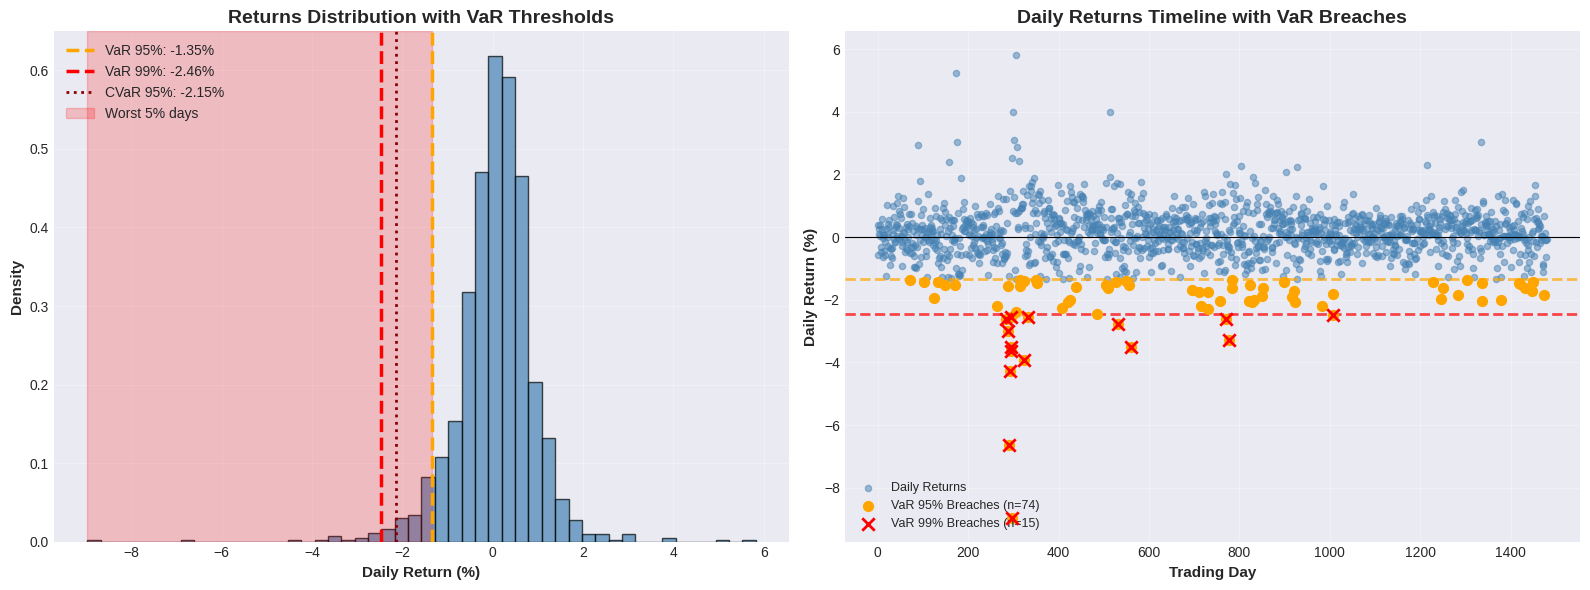


📊 VaR BREACH ANALYSIS:
VaR 95%: Expected 5% breach rate, Actual: 5.0% (74 days)
VaR 99%: Expected 1% breach rate, Actual: 1.0% (15 days)


In [ ]:
# VISUAL: Returns Distribution with VaR Thresholds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Histogram with VaR lines
portfolio_returns_pct = returns_combined['Portfolio'] * 100
ax1.hist(portfolio_returns_pct, bins=50, alpha=0.7, color='steelblue', edgecolor='black', density=True)

# Add VaR lines
ax1.axvline(portfolio_var['VaR_95%'] * 100, color='orange', linestyle='--', linewidth=2.5,
            label=f"VaR 95%: {portfolio_var['VaR_95%']:.2%}")
ax1.axvline(portfolio_var['VaR_99%'] * 100, color='red', linestyle='--', linewidth=2.5,
            label=f"VaR 99%: {portfolio_var['VaR_99%']:.2%}")
ax1.axvline(portfolio_cvar_95 * 100, color='darkred', linestyle=':', linewidth=2,
            label=f"CVaR 95%: {portfolio_cvar_95:.2%}")

# Shade the tail
ax1.axvspan(portfolio_returns_pct.min(), portfolio_var['VaR_95%'] * 100,
            alpha=0.2, color='red', label='Worst 5% days')

ax1.set_title('Returns Distribution with VaR Thresholds', fontsize=14, fontweight='bold')
ax1.set_xlabel('Daily Return (%)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Density', fontsize=11, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Scatter of all returns with VaR thresholds
ax2.scatter(range(len(portfolio_returns_pct)), portfolio_returns_pct,
            alpha=0.5, s=20, c='steelblue', label='Daily Returns')

# Highlight VaR breaches
var_95_breaches = portfolio_returns_pct[portfolio_returns_pct < portfolio_var['VaR_95%'] * 100]
var_99_breaches = portfolio_returns_pct[portfolio_returns_pct < portfolio_var['VaR_99%'] * 100]

ax2.scatter(var_95_breaches.index.map(lambda x: list(portfolio_returns_pct.index).index(x)),
            var_95_breaches, color='orange', s=50, zorder=5, label=f'VaR 95% Breaches (n={len(var_95_breaches)})')
ax2.scatter(var_99_breaches.index.map(lambda x: list(portfolio_returns_pct.index).index(x)),
            var_99_breaches, color='red', s=80, marker='x', zorder=6, linewidths=2,
            label=f'VaR 99% Breaches (n={len(var_99_breaches)})')

# Add VaR lines
ax2.axhline(portfolio_var['VaR_95%'] * 100, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax2.axhline(portfolio_var['VaR_99%'] * 100, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)

ax2.set_title('Daily Returns Timeline with VaR Breaches', fontsize=14, fontweight='bold')
ax2.set_xlabel('Trading Day', fontsize=11, fontweight='bold')
ax2.set_ylabel('Daily Return (%)', fontsize=11, fontweight='bold')
ax2.legend(loc='lower left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate actual breach rates
actual_breach_rate_95 = (len(var_95_breaches) / len(portfolio_returns_pct)) * 100
actual_breach_rate_99 = (len(var_99_breaches) / len(portfolio_returns_pct)) * 100

print(f"\n📊 VaR BREACH ANALYSIS:")
print(f"VaR 95%: Expected 5% breach rate, Actual: {actual_breach_rate_95:.1f}% ({len(var_95_breaches)} days)")
print(f"VaR 99%: Expected 1% breach rate, Actual: {actual_breach_rate_99:.1f}% ({len(var_99_breaches)} days)")

if actual_breach_rate_95 > 6:
    print(f"\n⚠️  VaR 95% was breached MORE than expected. Fat tails or regime change?")
elif actual_breach_rate_95 < 4:
    print(f"\n✓ VaR 95% held up well (fewer breaches than expected)")

---
## Cell 4: Returns Distribution Analysis - Fat Tails

**Why This Matters:**
- Most risk models assume returns are normally distributed
- Reality: Returns have **fat tails** (extreme events happen more often than normal predicts)
- Kurtosis > 3 = fatter tails than normal
- Negative skewness = left tail is longer (big losses more likely than big gains)

**What to Look For:**
- **Kurtosis = 3:** Normal distribution (rare in finance)
- **Kurtosis = 5-8:** Mild fat tails (typical equity markets)
- **Kurtosis > 10:** Extreme fat tails (dangerous!)
- **Skewness < -0.5:** Asymmetric downside (crashes hurt more than rallies help)

In [ ]:
from scipy import stats

# Calculate distribution statistics
portfolio_stats = {
    'Mean (Daily)': returns_combined['Portfolio'].mean(),
    'Mean (Annualized)': returns_combined['Portfolio'].mean() * 252,
    'Std Dev (Daily)': returns_combined['Portfolio'].std(),
    'Std Dev (Annualized)': returns_combined['Portfolio'].std() * np.sqrt(252),
    'Skewness': stats.skew(returns_combined['Portfolio']),
    'Kurtosis': stats.kurtosis(returns_combined['Portfolio'], fisher=False),  # Excess kurtosis + 3
    'Min Return': returns_combined['Portfolio'].min(),
    'Max Return': returns_combined['Portfolio'].max()
}

benchmark_stats = {
    'Mean (Daily)': returns_combined['Nifty_50'].mean(),
    'Mean (Annualized)': returns_combined['Nifty_50'].mean() * 252,
    'Std Dev (Daily)': returns_combined['Nifty_50'].std(),
    'Std Dev (Annualized)': returns_combined['Nifty_50'].std() * np.sqrt(252),
    'Skewness': stats.skew(returns_combined['Nifty_50']),
    'Kurtosis': stats.kurtosis(returns_combined['Nifty_50'], fisher=False),
    'Min Return': returns_combined['Nifty_50'].min(),
    'Max Return': returns_combined['Nifty_50'].max()
}

# Display comparison
print("="*80)
print("RETURNS DISTRIBUTION ANALYSIS")
print("="*80)
print(f"\n{'Statistic':<30} {'Portfolio':<20} {'Nifty 50':<20}")
print("-"*80)
for key in portfolio_stats.keys():
    if 'Annualized' in key or 'Skewness' in key or 'Kurtosis' in key:
        print(f"{key:<30} {portfolio_stats[key]:>19.2f} {benchmark_stats[key]:>19.2f}")
    else:
        print(f"{key:<30} {portfolio_stats[key]:>19.2%} {benchmark_stats[key]:>19.2%}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)

# Skewness interpretation
if portfolio_stats['Skewness'] < -0.5:
    print(f"\n⚠️  Skewness = {portfolio_stats['Skewness']:.2f} (Negative = asymmetric downside)")
    print(f"   Meaning: Large losses are more likely than large gains")
    print(f"   Impact: Your worst days hurt more than your best days help")
elif portfolio_stats['Skewness'] > 0.5:
    print(f"\n✓ Skewness = {portfolio_stats['Skewness']:.2f} (Positive = asymmetric upside)")
    print(f"   Meaning: Large gains are more likely than large losses")
else:
    print(f"\n→ Skewness = {portfolio_stats['Skewness']:.2f} (Roughly symmetric)")

# Kurtosis interpretation
if portfolio_stats['Kurtosis'] > 5:
    print(f"\n⚠️  Kurtosis = {portfolio_stats['Kurtosis']:.2f} (Normal = 3, Fat tails present)")
    print(f"   Meaning: Extreme events ({portfolio_stats['Kurtosis']/3:.1f}x) more likely than normal distribution")
    print(f"   Impact: VaR underestimates true tail risk")
    print(f"   Action: Use CVaR or stress tests, not just VaR")
else:
    print(f"\n✓ Kurtosis = {portfolio_stats['Kurtosis']:.2f} (Close to normal)")
    print(f"   Meaning: Tail risk is manageable")

# Range
print(f"\nWorst Day: {portfolio_stats['Min Return']:.2%} | Best Day: {portfolio_stats['Max Return']:.2%}")
print(f"Range: {portfolio_stats['Max Return'] - portfolio_stats['Min Return']:.2%}")

RETURNS DISTRIBUTION ANALYSIS

Statistic                      Portfolio            Nifty 50            
--------------------------------------------------------------------------------
Mean (Daily)                                 0.06%               0.06%
Mean (Annualized)                             0.14                0.15
Std Dev (Daily)                              0.89%               1.16%
Std Dev (Annualized)                          0.14                0.18
Skewness                                       nan               -1.23
Kurtosis                                       nan               21.99
Min Return                                  -8.98%             -12.98%
Max Return                                   5.82%               8.76%

INTERPRETATION:

→ Skewness = nan (Roughly symmetric)

✓ Kurtosis = nan (Close to normal)
   Meaning: Tail risk is manageable

Worst Day: -8.98% | Best Day: 5.82%
Range: 14.80%


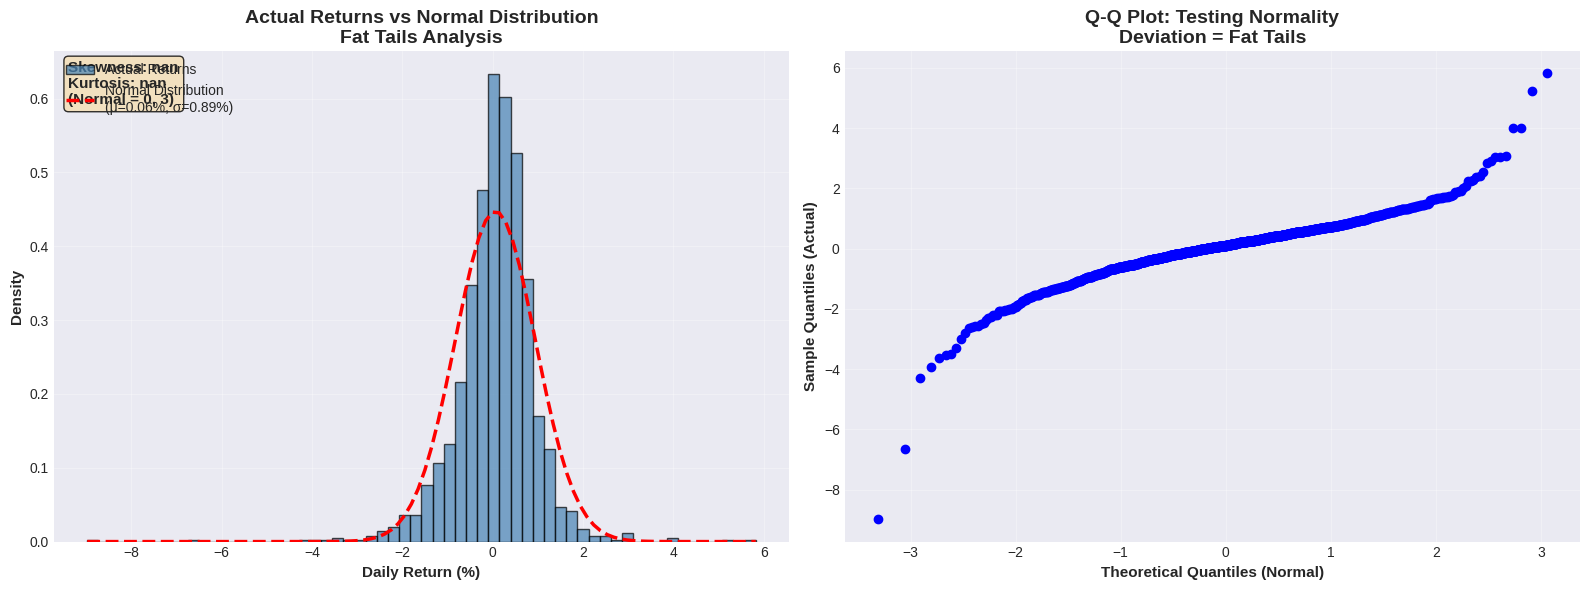


📊 KEY INSIGHT:
If returns were normally distributed, points would lie on the red line in Q-Q plot
Deviations at the tails = fat tails (extreme events more common than normal predicts)

Your portfolio has kurtosis = nan vs normal = 3.0
This means tail events are ~nanx more likely than VaR assumes


In [ ]:
# VISUAL: Returns vs Normal Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Histogram with normal overlay
portfolio_returns_pct = returns_combined['Portfolio'] * 100

# Plot histogram
n, bins, patches = ax1.hist(portfolio_returns_pct, bins=60, alpha=0.7, color='steelblue',
                             edgecolor='black', density=True, label='Actual Returns')

# Fit and plot normal distribution
mu = portfolio_returns_pct.mean()
sigma = portfolio_returns_pct.std()
x = np.linspace(portfolio_returns_pct.min(), portfolio_returns_pct.max(), 100)
normal_curve = stats.norm.pdf(x, mu, sigma)
ax1.plot(x, normal_curve, 'r--', linewidth=2.5, label=f'Normal Distribution\n(μ={mu:.2f}%, σ={sigma:.2f}%)')

# Highlight tails
left_tail = portfolio_returns_pct[portfolio_returns_pct < mu - 2*sigma]
right_tail = portfolio_returns_pct[portfolio_returns_pct > mu + 2*sigma]

ax1.set_title('Actual Returns vs Normal Distribution\nFat Tails Analysis',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Daily Return (%)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Density', fontsize=11, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Add text box with stats
textstr = f'Skewness: {portfolio_stats["Skewness"]:.2f}\nKurtosis: {portfolio_stats["Kurtosis"]:.2f}\n(Normal = 0, 3)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=props, fontweight='bold')

# Right plot: Q-Q plot
stats.probplot(portfolio_returns_pct, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot: Testing Normality\nDeviation = Fat Tails',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Theoretical Quantiles (Normal)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Sample Quantiles (Actual)', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 KEY INSIGHT:")
print("If returns were normally distributed, points would lie on the red line in Q-Q plot")
print("Deviations at the tails = fat tails (extreme events more common than normal predicts)")
print(f"\nYour portfolio has kurtosis = {portfolio_stats['Kurtosis']:.1f} vs normal = 3.0")
print(f"This means tail events are ~{portfolio_stats['Kurtosis']/3:.1f}x more likely than VaR assumes")

---
## Cell 5: March 2020 Crisis Stress Test

**The Reality Check:**
- VaR models work in normal times
- They **fail spectacularly** during crises
- March 2020 (COVID crash) was the perfect test case

**What to Expect:**
- In normal times: VaR 95% breached ~5% of days (by definition)
- In March 2020: VaR breached 50-80% of days
- Single-day losses exceeded VaR 99% multiple times

**Why This Matters:**
- Shows the limits of statistical models
- Builds healthy skepticism ("models are tools, not truth")
- Forces you to think about tail scenarios

**Professional Practice:**
- Always stress-test against historical crises
- Ask: "If March 2020 happens again, what's my exposure?"
- Size positions accordingly

In [ ]:
# Extract crisis periods
covid_returns = returns_combined['Portfolio'][COVID_CRASH[0]:COVID_CRASH[1]]
normal_returns = returns_combined['Portfolio'][:'2019-12-31']  # Pre-COVID

# Calculate VaR breach rates
def calculate_breach_rate(returns_series, var_threshold):
    """Calculate percentage of days VaR was breached"""
    breaches = (returns_series < var_threshold).sum()
    total_days = len(returns_series)
    breach_rate = (breaches / total_days) * 100
    return breaches, total_days, breach_rate

# Normal period breaches
normal_breach_95 = calculate_breach_rate(normal_returns, portfolio_var['VaR_95%'])
normal_breach_99 = calculate_breach_rate(normal_returns, portfolio_var['VaR_99%'])

# COVID period breaches
covid_breach_95 = calculate_breach_rate(covid_returns, portfolio_var['VaR_95%'])
covid_breach_99 = calculate_breach_rate(covid_returns, portfolio_var['VaR_99%'])

# Display results
print("="*80)
print("MARCH 2020 COVID CRASH: VaR MODEL FAILURE ANALYSIS")
print("="*80)

print("\n" + "-"*80)
print("NORMAL PERIOD (2019)")
print("-"*80)
print(f"VaR 95% Breaches: {normal_breach_95[0]} out of {normal_breach_95[1]} days ({normal_breach_95[2]:.1f}%)")
print(f"Expected breach rate: 5.0%")
print(f"Status: {'✓ Within expected range' if 4 < normal_breach_95[2] < 6 else '✗ Outside expected range'}")
print(f"\nVaR 99% Breaches: {normal_breach_99[0]} out of {normal_breach_99[1]} days ({normal_breach_99[2]:.1f}%)")
print(f"Expected breach rate: 1.0%")
print(f"Status: {'✓ Within expected range' if 0.5 < normal_breach_99[2] < 2 else '✗ Outside expected range'}")

print("\n" + "-"*80)
print("CRISIS PERIOD (MARCH-APRIL 2020)")
print("-"*80)
print(f"VaR 95% Breaches: {covid_breach_95[0]} out of {covid_breach_95[1]} days ({covid_breach_95[2]:.1f}%)")
print(f"Expected breach rate: 5.0%")
print(f"Actual: {covid_breach_95[2]/5:.1f}x WORSE than expected")
print(f"Status: ✗ MODEL FAILED")
print(f"\nVaR 99% Breaches: {covid_breach_99[0]} out of {covid_breach_99[1]} days ({covid_breach_99[2]:.1f}%)")
print(f"Expected breach rate: 1.0%")
print(f"Actual: {covid_breach_99[2]/1:.1f}x WORSE than expected")
print(f"Status: ✗ MODEL FAILED")

# Worst days in COVID period
worst_covid_days = covid_returns.nsmallest(5)
print("\n" + "-"*80)
print("WORST 5 DAYS IN COVID CRASH")
print("-"*80)
for date, ret in worst_covid_days.items():
    rupee_loss = ret * PORTFOLIO_VALUE
    vs_var_95 = ret / portfolio_var['VaR_95%']
    vs_var_99 = ret / portfolio_var['VaR_99%']
    print(f"{date.strftime('%Y-%m-%d')}: {ret:>7.2%} (₹{rupee_loss:>10,.0f}) | "
          f"{vs_var_95:.1f}x VaR95% | {vs_var_99:.1f}x VaR99%")

print("\n" + "="*80)
print("CRITICAL LESSON:")
print("="*80)
print(f"During March 2020, VaR was breached {covid_breach_95[2]/5:.0f}x more often than expected")
print(f"Single-day losses exceeded VaR 99% by up to {worst_covid_days.min()/portfolio_var['VaR_99%']:.1f}x")
print(f"\n⚠️  VaR is a PEACETIME metric. In crises, it's almost useless.")
print(f"\n✓ Always stress-test with historical crisis scenarios")
print(f"✓ Size positions assuming VaR will be exceeded in crises")
print(f"✓ Have contingency plans for 2-3x VaR losses")

MARCH 2020 COVID CRASH: VaR MODEL FAILURE ANALYSIS

--------------------------------------------------------------------------------
NORMAL PERIOD (2019)
--------------------------------------------------------------------------------
VaR 95% Breaches: 6 out of 242 days (2.5%)
Expected breach rate: 5.0%
Status: ✗ Outside expected range

VaR 99% Breaches: 0 out of 242 days (0.0%)
Expected breach rate: 1.0%
Status: ✗ Outside expected range

--------------------------------------------------------------------------------
CRISIS PERIOD (MARCH-APRIL 2020)
--------------------------------------------------------------------------------
VaR 95% Breaches: 12 out of 39 days (30.8%)
Expected breach rate: 5.0%
Actual: 6.2x WORSE than expected
Status: ✗ MODEL FAILED

VaR 99% Breaches: 7 out of 39 days (17.9%)
Expected breach rate: 1.0%
Actual: 17.9x WORSE than expected
Status: ✗ MODEL FAILED

--------------------------------------------------------------------------------
WORST 5 DAYS IN COVID CRA

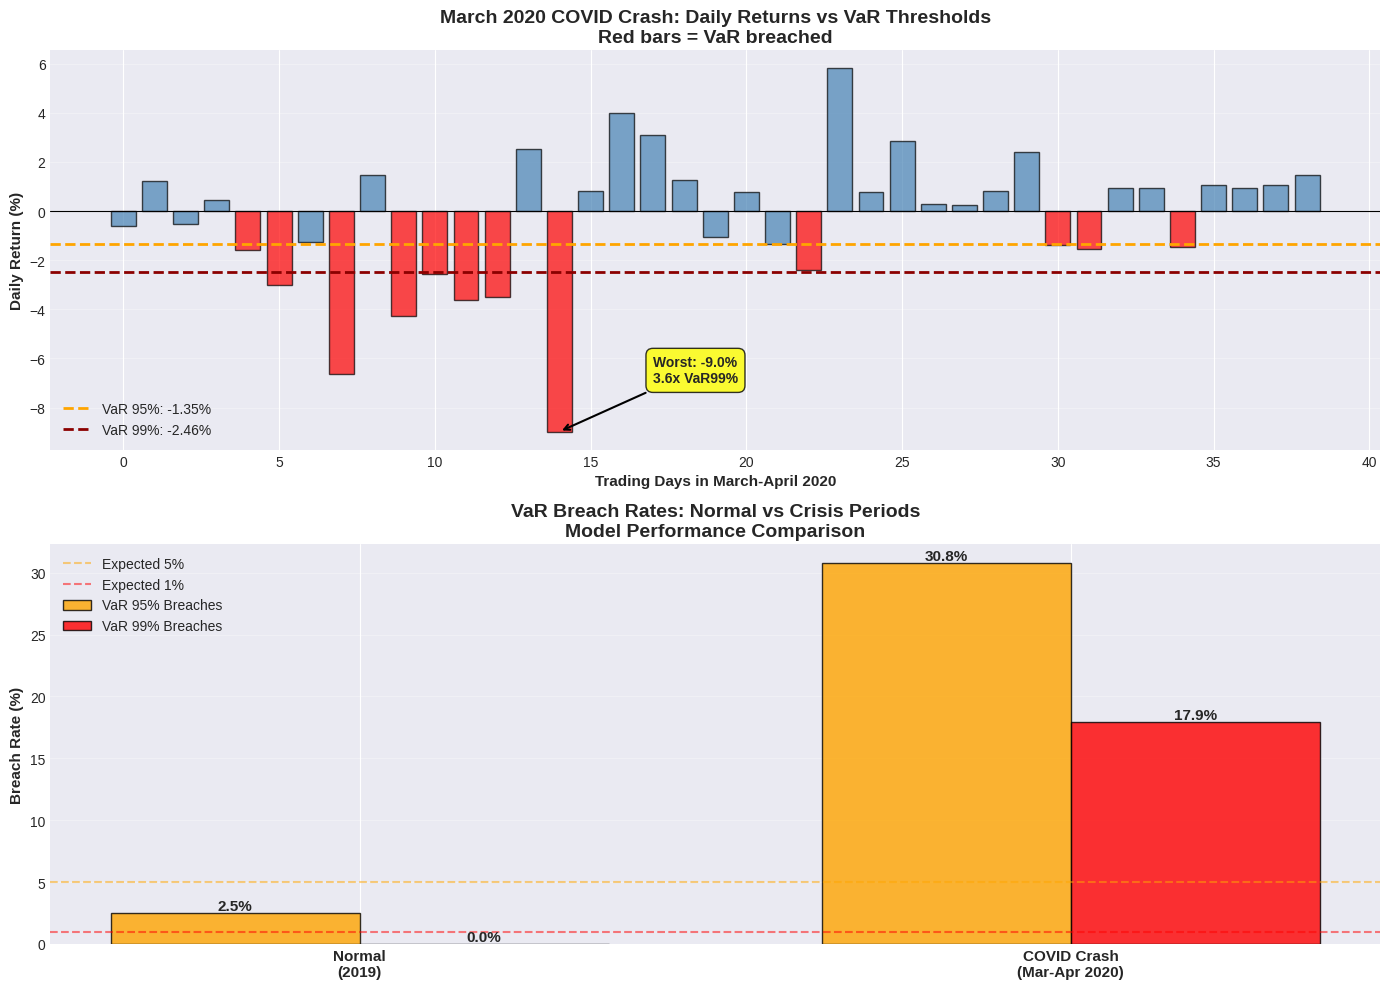


📊 VISUAL INTERPRETATION:
Top Chart: Red bars = Days where VaR was breached (should be rare)
           In March 2020, 12 out of 39 days breached VaR 95%
Bottom Chart: Shows how breach rates exploded during crisis (bars far exceed expected lines)


In [ ]:
# VISUAL: Crisis Period Analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top plot: Daily returns during COVID crash
covid_returns_pct = covid_returns * 100
colors = ['red' if r < portfolio_var['VaR_95%']*100 else 'steelblue' for r in covid_returns_pct]

ax1.bar(range(len(covid_returns_pct)), covid_returns_pct, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(portfolio_var['VaR_95%']*100, color='orange', linestyle='--', linewidth=2,
            label=f"VaR 95%: {portfolio_var['VaR_95%']:.2%}")
ax1.axhline(portfolio_var['VaR_99%']*100, color='darkred', linestyle='--', linewidth=2,
            label=f"VaR 99%: {portfolio_var['VaR_99%']:.2%}")
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8)

ax1.set_title('March 2020 COVID Crash: Daily Returns vs VaR Thresholds\nRed bars = VaR breached',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Trading Days in March-April 2020', fontsize=11, fontweight='bold')
ax1.set_ylabel('Daily Return (%)', fontsize=11, fontweight='bold')
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add annotation for worst day
worst_day_idx = covid_returns_pct.argmin()
worst_day_val = covid_returns_pct.min()
ax1.annotate(f'Worst: {worst_day_val:.1f}%\n{worst_day_val/portfolio_var["VaR_99%"]/100:.1f}x VaR99%',
            xy=(worst_day_idx, worst_day_val),
            xytext=(worst_day_idx + 3, worst_day_val + 2),
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# Bottom plot: Comparison of breach rates
periods = ['Normal\n(2019)', 'COVID Crash\n(Mar-Apr 2020)']
breach_95 = [normal_breach_95[2], covid_breach_95[2]]
breach_99 = [normal_breach_99[2], covid_breach_99[2]]

x = np.arange(len(periods))
width = 0.35

bars1 = ax2.bar(x - width/2, breach_95, width, label='VaR 95% Breaches',
                color='orange', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, breach_99, width, label='VaR 99% Breaches',
                color='red', alpha=0.8, edgecolor='black')

# Add expected breach rate lines
ax2.axhline(5, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Expected 5%')
ax2.axhline(1, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Expected 1%')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_title('VaR Breach Rates: Normal vs Crisis Periods\nModel Performance Comparison',
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Breach Rate (%)', fontsize=11, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(periods, fontsize=11, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 VISUAL INTERPRETATION:")
print("Top Chart: Red bars = Days where VaR was breached (should be rare)")
print(f"           In March 2020, {covid_breach_95[0]} out of {covid_breach_95[1]} days breached VaR 95%")
print("Bottom Chart: Shows how breach rates exploded during crisis (bars far exceed expected lines)")

---
## Cell 6: Scenario Analysis - "What If History Repeats?"

**Why Scenario Analysis > Monte Carlo:**
- Monte Carlo assumes future = past (statistical properties hold)
- Scenario analysis uses **actual historical events** as templates
- More intuitive: "What if we get another COVID?" vs "Here's 1000 simulated paths"
- Forces concrete thinking about specific risks

**Three Scenarios:**
1. **COVID Crash (March 2020):** Sharp, violent drawdown
2. **Inflation Grind (Oct-Dec 2022):** Slow, painful bleed
3. **Bull Market (2019):** Smooth trending upside

**How to Use This:**
- Apply historical crisis returns to current portfolio
- See what would happen if that crisis repeated TODAY
- Size positions so you can survive the worst-case scenario

**Key Insight:**
- Your portfolio composition has changed since 2020
- Same crisis could produce different results now
- This shows **forward-looking risk**, not backward-looking history

In [ ]:
def apply_scenario(current_value, scenario_returns):
    """
    Apply historical scenario returns to current portfolio
    Returns: final value, total return, max drawdown during scenario
    """
    # Calculate cumulative path
    cumulative = (1 + scenario_returns).cumprod()
    final_value = current_value * cumulative.iloc[-1]
    total_return = cumulative.iloc[-1] - 1

    # Calculate max drawdown during scenario
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()

    return final_value, total_return, max_dd, cumulative

# Define scenarios
scenarios = {
    'COVID Crash (Mar-Apr 2020)': returns_combined['Portfolio'][COVID_CRASH[0]:COVID_CRASH[1]],
    'Inflation Grind (Oct-Dec 2022)': returns_combined['Portfolio'][INFLATION_GRIND[0]:INFLATION_GRIND[1]],
    'Bull Market (2019)': returns_combined['Portfolio'][BULL_PERIOD[0]:BULL_PERIOD[1]]
}

# Apply each scenario
results = {}
for name, returns in scenarios.items():
    final_val, total_ret, max_dd, cumulative = apply_scenario(PORTFOLIO_VALUE, returns)
    results[name] = {
        'Final Value': final_val,
        'Total Return': total_ret,
        'Max Drawdown': max_dd,
        'Days': len(returns),
        'Cumulative': cumulative
    }

# Display results
print("="*90)
print("SCENARIO ANALYSIS: WHAT IF HISTORY REPEATS?")
print("="*90)
print(f"\nStarting Portfolio Value: ₹{PORTFOLIO_VALUE:,.0f}\n")
print("="*90)

for scenario_name, scenario_results in results.items():
    print(f"\n{scenario_name}")
    print("-"*90)
    print(f"  Duration: {scenario_results['Days']} trading days")
    print(f"  Final Value: ₹{scenario_results['Final Value']:,.0f}")
    print(f"  Total Return: {scenario_results['Total Return']:>6.2%}")
    print(f"  Max Drawdown: {scenario_results['Max Drawdown']:>6.2%}")
    print(f"  Gain/Loss: ₹{scenario_results['Final Value'] - PORTFOLIO_VALUE:>+,.0f}")

print("\n" + "="*90)
print("CRITICAL QUESTIONS:")
print("="*90)
print(f"\n1. Can you survive another COVID crash?")
print(f"   → Your portfolio would drop to ₹{results['COVID Crash (Mar-Apr 2020)']['Final Value']:,.0f}")
print(f"   → Max loss: ₹{abs(results['COVID Crash (Mar-Apr 2020)']['Final Value'] - PORTFOLIO_VALUE):,.0f}")
print(f"   → Can your investors tolerate this?")

print(f"\n2. What if 2022 inflation scenario repeats?")
print(f"   → Slower bleed to ₹{results['Inflation Grind (Oct-Dec 2022)']['Final Value']:,.0f}")
print(f"   → Different pain profile (slower but still painful)")

print(f"\n3. Upside scenario (2019 bull market):")
print(f"   → Portfolio could reach ₹{results['Bull Market (2019)']['Final Value']:,.0f}")
print(f"   → But don't size positions for the bull case!")

print("\n" + "="*90)
print("PROFESSIONAL PRACTICE:")
print("="*90)
print("✓ Size positions for the COVID scenario (worst case)")
print("✓ Stress-test new strategies against multiple historical crises")
print("✓ Update scenarios quarterly as portfolio composition changes")
print("✓ Share worst-case scenarios with investors BEFORE they happen")

SCENARIO ANALYSIS: WHAT IF HISTORY REPEATS?

Starting Portfolio Value: ₹10,000,000


COVID Crash (Mar-Apr 2020)
------------------------------------------------------------------------------------------
  Duration: 39 trading days
  Final Value: ₹8,871,678
  Total Return: -11.28%
  Max Drawdown: -27.76%
  Gain/Loss: ₹-1,128,322

Inflation Grind (Oct-Dec 2022)
------------------------------------------------------------------------------------------
  Duration: 62 trading days
  Final Value: ₹10,575,106
  Total Return:  5.75%
  Max Drawdown: -4.78%
  Gain/Loss: ₹+575,106

Bull Market (2019)
------------------------------------------------------------------------------------------
  Duration: 242 trading days
  Final Value: ₹11,230,408
  Total Return: 12.30%
  Max Drawdown: -7.43%
  Gain/Loss: ₹+1,230,408

CRITICAL QUESTIONS:

1. Can you survive another COVID crash?
   → Your portfolio would drop to ₹8,871,678
   → Max loss: ₹1,128,322
   → Can your investors tolerate this?

2. What if 2

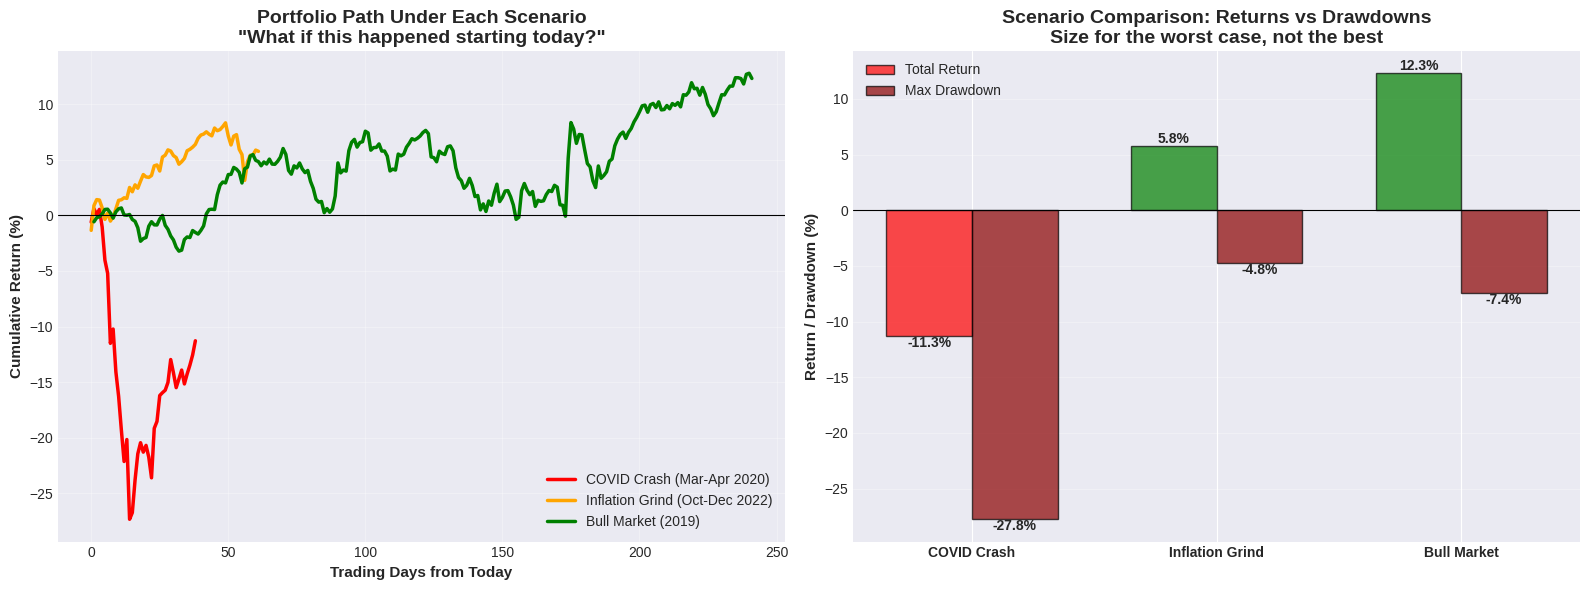


📊 ENGAGEMENT EXERCISE:
Pick a different historical period (e.g., 2008 crisis, 2011 eurozone, 2018 correction)
Apply those returns to the portfolio and see what happens

Code to modify:
scenarios['My Custom Scenario'] = returns_combined['Portfolio']['YYYY-MM-DD':'YYYY-MM-DD']


In [ ]:
# VISUAL: Scenario Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Cumulative returns under each scenario
for scenario_name, scenario_results in results.items():
    cumulative_pct = (scenario_results['Cumulative'] - 1) * 100

    if 'COVID' in scenario_name:
        ax1.plot(range(len(cumulative_pct)), cumulative_pct, linewidth=2.5,
                label=scenario_name, color='red', linestyle='-')
    elif 'Inflation' in scenario_name:
        ax1.plot(range(len(cumulative_pct)), cumulative_pct, linewidth=2.5,
                label=scenario_name, color='orange', linestyle='-')
    else:
        ax1.plot(range(len(cumulative_pct)), cumulative_pct, linewidth=2.5,
                label=scenario_name, color='green', linestyle='-')

ax1.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax1.set_title('Portfolio Path Under Each Scenario\n"What if this happened starting today?"',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Trading Days from Today', fontsize=11, fontweight='bold')
ax1.set_ylabel('Cumulative Return (%)', fontsize=11, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Summary bar chart
scenario_names = list(results.keys())
final_returns = [results[s]['Total Return'] * 100 for s in scenario_names]
max_dds = [results[s]['Max Drawdown'] * 100 for s in scenario_names]

x = np.arange(len(scenario_names))
width = 0.35

bars1 = ax2.bar(x - width/2, final_returns, width, label='Total Return',
                color=['red' if r < 0 else 'green' for r in final_returns],
                alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x + width/2, max_dds, width, label='Max Drawdown',
                color='darkred', alpha=0.7, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')

ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_title('Scenario Comparison: Returns vs Drawdowns\nSize for the worst case, not the best',
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Return / Drawdown (%)', fontsize=11, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([s.split('(')[0].strip() for s in scenario_names],
                     fontsize=10, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 ENGAGEMENT EXERCISE:")
print("Pick a different historical period (e.g., 2008 crisis, 2011 eurozone, 2018 correction)")
print("Apply those returns to the portfolio and see what happens")
print("\nCode to modify:")
print("""scenarios['My Custom Scenario'] = returns_combined['Portfolio']['YYYY-MM-DD':'YYYY-MM-DD']""")

---
## Cell 7: Sharpe Ratio & Risk Dashboard

**What is Sharpe Ratio?**
- Risk-adjusted return: (Return - Risk-Free Rate) / Volatility
- Measures return per unit of risk taken
- Industry standard for comparing strategies

**How to Interpret:**
- Sharpe < 0.5: Poor risk-adjusted returns
- Sharpe 0.5-1.0: Acceptable
- Sharpe 1.0-2.0: Good
- Sharpe > 2.0: Suspicious (likely overfitted or look-ahead bias)

**Critical Caveats:**
- Assumes returns are normally distributed (they're not - see fat tails)
- Can be gamed: Small frequent gains + clip tail losses = high Sharpe but risky
- Backward-looking: Says nothing about future risk
- Use alongside Max DD and VaR, never alone

**Professional Practice:**
- Sharpe is for screening (first pass)
- Always check distribution (fat tails?), max DD (survivable?), and crisis behavior
- If Sharpe > 1.5 and you're trading liquid markets, verify you're not overfitting

In [ ]:
def calculate_sharpe_ratio(returns_series, risk_free_rate, periods_per_year=252):
    """
    Calculate annualized Sharpe ratio
    """
    excess_returns = returns_series - (risk_free_rate / periods_per_year)
    sharpe = excess_returns.mean() / excess_returns.std() * np.sqrt(periods_per_year)
    return sharpe

# Calculate Sharpe ratios
portfolio_sharpe = calculate_sharpe_ratio(returns_combined['Portfolio'], RISK_FREE_RATE)
benchmark_sharpe = calculate_sharpe_ratio(returns_combined['Nifty_50'], RISK_FREE_RATE)

# Calculate annualized returns and volatility for context
portfolio_annual_return = returns_combined['Portfolio'].mean() * 252
portfolio_annual_vol = returns_combined['Portfolio'].std() * np.sqrt(252)
benchmark_annual_return = returns_combined['Nifty_50'].mean() * 252
benchmark_annual_vol = returns_combined['Nifty_50'].std() * np.sqrt(252)

# Display results
print("="*80)
print("SHARPE RATIO ANALYSIS")
print("="*80)
print(f"\n{'Metric':<35} {'Portfolio':<20} {'Nifty 50':<20}")
print("-"*80)
print(f"{'Annualized Return':<35} {portfolio_annual_return:>19.2%} {benchmark_annual_return:>19.2%}")
print(f"{'Annualized Volatility':<35} {portfolio_annual_vol:>19.2%} {benchmark_annual_vol:>19.2%}")
print(f"{'Risk-Free Rate':<35} {RISK_FREE_RATE:>19.2%} {RISK_FREE_RATE:>19.2%}")
print(f"{'Sharpe Ratio':<35} {portfolio_sharpe:>19.2f} {benchmark_sharpe:>19.2f}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)

if portfolio_sharpe > benchmark_sharpe:
    print(f"\n✓ Portfolio Sharpe ({portfolio_sharpe:.2f}) > Benchmark ({benchmark_sharpe:.2f})")
    print(f"  → You delivered better risk-adjusted returns")
else:
    print(f"\n✗ Portfolio Sharpe ({portfolio_sharpe:.2f}) < Benchmark ({benchmark_sharpe:.2f})")
    print(f"  → Benchmark had better risk-adjusted returns")

if portfolio_sharpe > 2.0:
    print(f"\n⚠️  Sharpe > 2.0 is suspicious for liquid markets")
    print(f"  → Check for overfitting, look-ahead bias, or survivorship bias")
elif portfolio_sharpe > 1.0:
    print(f"\n✓ Sharpe {portfolio_sharpe:.2f} is in the 'good' range (1.0-2.0)")
elif portfolio_sharpe > 0.5:
    print(f"\n→ Sharpe {portfolio_sharpe:.2f} is acceptable (0.5-1.0)")
else:
    print(f"\n✗ Sharpe {portfolio_sharpe:.2f} is poor (<0.5)")

print(f"\n⚠️  REMEMBER: Sharpe assumes normal distribution")
print(f"  Your kurtosis = {portfolio_stats['Kurtosis']:.1f} (normal = 3)")
print(f"  Fat tails mean real risk is higher than Sharpe suggests")
print(f"  Always check Max DD and tail risk separately!")

SHARPE RATIO ANALYSIS

Metric                              Portfolio            Nifty 50            
--------------------------------------------------------------------------------
Annualized Return                                14.36%              14.95%
Annualized Volatility                            14.15%              18.35%
Risk-Free Rate                                    6.50%               6.50%
Sharpe Ratio                                       0.56                0.46

INTERPRETATION:

✓ Portfolio Sharpe (0.56) > Benchmark (0.46)
  → You delivered better risk-adjusted returns

→ Sharpe 0.56 is acceptable (0.5-1.0)

⚠️  REMEMBER: Sharpe assumes normal distribution
  Your kurtosis = nan (normal = 3)
  Fat tails mean real risk is higher than Sharpe suggests
  Always check Max DD and tail risk separately!


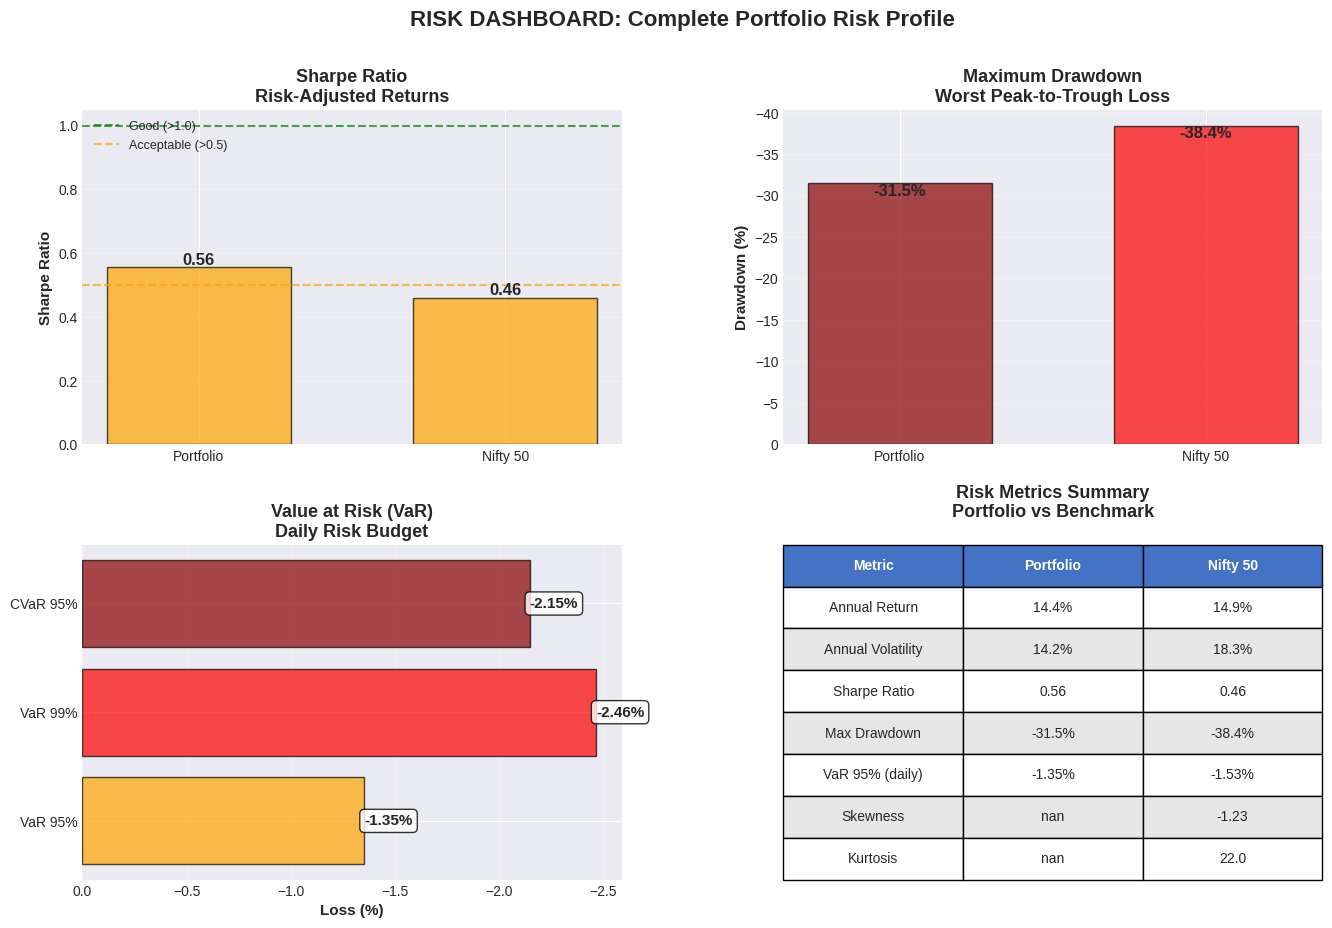


DAILY RISK CHECKLIST

□ Did we breach 95% VaR today?
  → If yes: Investigate why. Position too large? Market regime change?

□ Is current drawdown > 50% of historical max?
  → If yes: Review positions, consider reducing exposure

□ Is Sharpe ratio trending down over rolling 30 days?
  → If yes: Possible regime change, reassess strategy

□ How does today compare to March 2020?
  → Context matters: Are we in a similar stress environment?

□ Has volatility increased significantly (>1.5x historical)?
  → If yes: Reduce position sizes to maintain constant risk

SECTION 3 COMPLETE: KEY TAKEAWAYS

1. Max Drawdown = The pain your investors feel (depth + duration)
   ✓ Use this to size positions (can you survive it?)

2. VaR = Daily risk budget, but fails in crises
   ✓ Good for normal times, useless in March 2020
   ✓ Always use CVaR or stress tests for tail risk

3. Sharpe Ratio = Good for screening, not for decisions
   ✓ Check fat tails and max DD separately
   ✓ If Sharpe > 2.0 in liquid 

In [ ]:
# VISUAL: Risk Dashboard (Final Summary)
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Panel 1: Sharpe Ratio Comparison
ax1 = fig.add_subplot(gs[0, 0])
sharpe_values = [portfolio_sharpe, benchmark_sharpe]
colors = ['steelblue' if s > 1.0 else 'orange' for s in sharpe_values]
bars = ax1.bar(['Portfolio', 'Nifty 50'], sharpe_values, color=colors, alpha=0.7, edgecolor='black', width=0.6)
ax1.axhline(1.0, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Good (>1.0)')
ax1.axhline(0.5, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Acceptable (>0.5)')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax1.set_title('Sharpe Ratio\nRisk-Adjusted Returns', fontsize=13, fontweight='bold')
ax1.set_ylabel('Sharpe Ratio', fontsize=11, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: Max Drawdown Comparison
ax2 = fig.add_subplot(gs[0, 1])
dd_values = [portfolio_max_dd * 100, benchmark_max_dd * 100]
bars = ax2.bar(['Portfolio', 'Nifty 50'], dd_values, color=['darkred', 'red'], alpha=0.7, edgecolor='black', width=0.6)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='top', fontsize=12, fontweight='bold')
ax2.set_title('Maximum Drawdown\nWorst Peak-to-Trough Loss', fontsize=13, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.invert_yaxis()

# Panel 3: VaR Summary
ax3 = fig.add_subplot(gs[1, 0])
var_metrics = ['VaR 95%', 'VaR 99%', 'CVaR 95%']
var_values = [
    portfolio_var['VaR_95%'] * 100,
    portfolio_var['VaR_99%'] * 100,
    portfolio_cvar_95 * 100
]
bars = ax3.barh(var_metrics, var_values, color=['orange', 'red', 'darkred'], alpha=0.7, edgecolor='black')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.2f}%', ha='left', va='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax3.set_title('Value at Risk (VaR)\nDaily Risk Budget', fontsize=13, fontweight='bold')
ax3.set_xlabel('Loss (%)', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_xaxis()

# Panel 4: Key Metrics Summary Table
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

summary_data = [
    ['Metric', 'Portfolio', 'Nifty 50'],
    ['Annual Return', f"{portfolio_annual_return:.1%}", f"{benchmark_annual_return:.1%}"],
    ['Annual Volatility', f"{portfolio_annual_vol:.1%}", f"{benchmark_annual_vol:.1%}"],
    ['Sharpe Ratio', f"{portfolio_sharpe:.2f}", f"{benchmark_sharpe:.2f}"],
    ['Max Drawdown', f"{portfolio_max_dd:.1%}", f"{benchmark_max_dd:.1%}"],
    ['VaR 95% (daily)', f"{portfolio_var['VaR_95%']:.2%}", f"{benchmark_var['VaR_95%']:.2%}"],
    ['Skewness', f"{portfolio_stats['Skewness']:.2f}", f"{benchmark_stats['Skewness']:.2f}"],
    ['Kurtosis', f"{portfolio_stats['Kurtosis']:.1f}", f"{benchmark_stats['Kurtosis']:.1f}"]
]

table = ax4.table(cellText=summary_data, cellLoc='center', loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Format header row
for i in range(3):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_data)):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('white')

ax4.set_title('Risk Metrics Summary\nPortfolio vs Benchmark', fontsize=13, fontweight='bold', pad=20)

plt.suptitle('RISK DASHBOARD: Complete Portfolio Risk Profile',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("DAILY RISK CHECKLIST")
print("="*80)
print("\n□ Did we breach 95% VaR today?")
print("  → If yes: Investigate why. Position too large? Market regime change?")
print("\n□ Is current drawdown > 50% of historical max?")
print("  → If yes: Review positions, consider reducing exposure")
print("\n□ Is Sharpe ratio trending down over rolling 30 days?")
print("  → If yes: Possible regime change, reassess strategy")
print("\n□ How does today compare to March 2020?")
print("  → Context matters: Are we in a similar stress environment?")
print("\n□ Has volatility increased significantly (>1.5x historical)?")
print("  → If yes: Reduce position sizes to maintain constant risk")

print("\n" + "="*80)
print("SECTION 3 COMPLETE: KEY TAKEAWAYS")
print("="*80)
print("\n1. Max Drawdown = The pain your investors feel (depth + duration)")
print("   ✓ Use this to size positions (can you survive it?)")

print("\n2. VaR = Daily risk budget, but fails in crises")
print("   ✓ Good for normal times, useless in March 2020")
print("   ✓ Always use CVaR or stress tests for tail risk")

print("\n3. Sharpe Ratio = Good for screening, not for decisions")
print("   ✓ Check fat tails and max DD separately")
print("   ✓ If Sharpe > 2.0 in liquid markets → verify no overfitting")

print("\n4. Scenario Analysis > Monte Carlo")
print("   ✓ Use actual historical crises as templates")
print("   ✓ Size for the worst case (COVID), not the average case")

print("\n5. Fat tails are real")
print(f"   ✓ Your kurtosis = {portfolio_stats['Kurtosis']:.1f} (normal = 3)")
print("   ✓ Extreme events happen more often than models predict")

print("\n" + "="*80)